# 🔲 Regularization in Logistic Regression 

**Regularization** refers to techniques that are used to calibrate machine learning models in order to minimize the adjusted loss function and prevent overfitting or underfitting. Using Regularization, we can fit our machine learning model appropriately on a given test set and hence reduce the errors in it.

<center><img src="images/regularization.png" width=1100></center>

In this notebook, we would like to make a binary classification using regression.

In order to do so, we would like to explore a dataset representing the commercialization of a product given two quality tests performed on that latest. We will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. 

Since we already made a gradient descent algorithm for Logistic Regression on our <a href="https://github.com/kawaremu/MLFromScratch/blob/main/Logistic%20Regression.ipynb">previous notebook</a>, we are going to add a regularization feature to it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']

In [2]:
plt.style.use('seaborn-whitegrid')

In [3]:
df_products = pd.read_csv('data/products.csv')
df_products.head()

,test1,test2,commercialized
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
features = ['test1', 'test2']
target = 'commercialized'

In [5]:
X = df_products[features].values
y = df_products[target].values.astype(np.int32).reshape(-1,1)
X.shape,y.shape

((118, 2), (118, 1))

In [6]:
X[:5],y[:5]

(array([[ 0.051267,  0.69956 ],
        [-0.092742,  0.68494 ],
        [-0.21371 ,  0.69225 ],
        [-0.375   ,  0.50219 ],
        [-0.51325 ,  0.46564 ]]),
 array([[1],
        [1],
        [1],
        [1],
        [1]]))

# 🦮 Data Exploration

A machine learning model and conclusions cannot be made without exploration and visualisation.


<AxesSubplot:xlabel='commercialized', ylabel='count'>

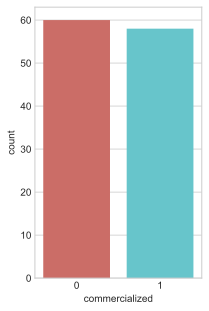

In [7]:
plt.figure(figsize=(3,5))
sns.countplot(x='commercialized',data=df_products,palette='hls')

<AxesSubplot:xlabel='test1', ylabel='test2'>

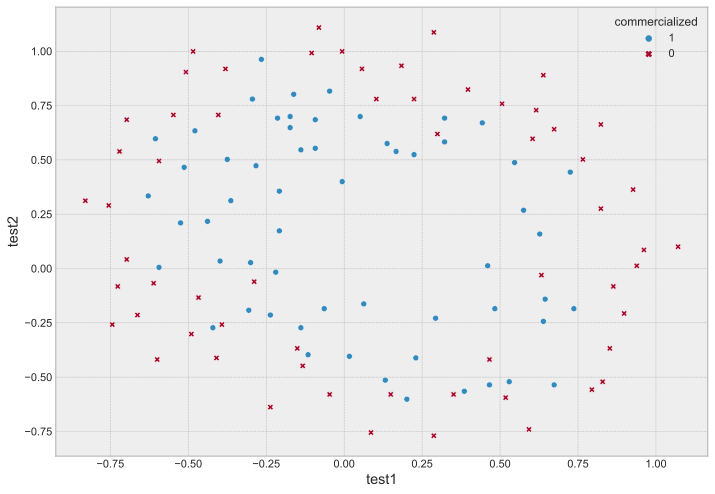

In [8]:
sns.set_context("paper")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.style.use('bmh')
markers = {1: "o", 0: "X"}
hue_order = [1,0]
sns.scatterplot(data=df_products, x="test1", y="test2",hue="commercialized",style="commercialized",markers=markers,hue_order=hue_order,sizes=40)

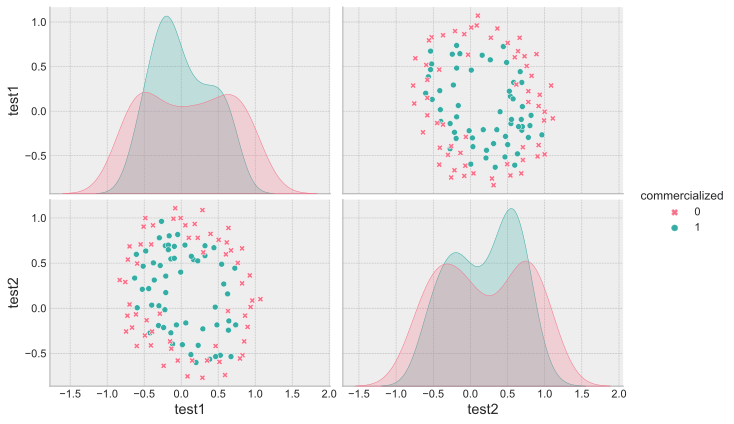

In [9]:
sns.pairplot(df_products, hue='commercialized', height=3,aspect=1.5, palette="husl",markers=["X", "o"])

The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

# 👩🏻‍🏫 The problem of Under/Overfitting

In our <a>Linear Regression notebook</a>, we tried to predict the benefice of a village given its number of inhabitants.

<center><img src="images\linear_regression_notebook1.png"></center>


However, some points seem to be *wrongly* misplaced and are not fitting to the line. This means that our model performed poorly and is facing the *Underfitting* problem (or is highly biaised).

It is basically fitting a line to the data and our model has a very strong preconception/biais that our features variables are going to vary linearly with the target. 


Same problem happened when we did our predictions on the logistic regression problem, some data points are labeled as belonging to the wrong class; it is because the model is too *rigid* at its prediction.

<center><img src="images\draw_boundaries_logistic.png"></center>

In the other side, there is the *Overfitting* problem where the learned hypothesis may fit the training set very well (when we have too many features),but fails to generalize to new examples.

- What are the causes of Overfitting ?
  1. When including "irrelevant features", the model will learn every feature we included in it, regardless whether that feature has impact or is noisy (high variance data),

  2. Features that are highly correlated or co-linear can cause overfitting. Multicollinearity happens when independent variables in the regression model are highly correlated to each other. It causes unstability in the data.

  3. Linear models can over-fit if the coefficients (after feature standardization) are too large. Larger the absolute value of the coefficient, more power it gives to the predicted value, resulting in a higher variance.



# 🤔 What is the solution ? Regularization !

The implementation of Gradient Descent we did previously had no regularization. Because of this, our model is likely to either overfit or underfit the training data.


There are many ways to combat overfitting, we can cite : 
- Reduce the number of features manually.  
    
- **Regularization** : keeping all the features but reduce the magnitude/values of parameters $\theta_j$


Regularization is a method for “constraining” or “regularizing” the size of the coefficients, thus “shrinking” them towards zero.

L1 regularization *(also known as L1 norm or Lasso)* and L2 regularization *(or the L2 norm, or Ridge)* are 2 popular regularization techniques we could use to combat the overfitting in our model. 

L2 regularization combats overfitting by forcing weights to be small, but not making them exactly 0. On the other hand,  L1 combats overfitting by shrinking the parameters towards 0. This makes some features obsolete. 

In this notebook, we will dive into Ridge Regularization (the other one will come when we will start talking about neural networks).

## 🔖 Feature mapping

One way to fit the data better is to create more features from each data point .In the following function mapFeature, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

$x_0 \rightarrow 1$

$x_1 \rightarrow x_1$

$x_2 \rightarrow x_2$

$x_3 \rightarrow {x_1}^2$

$x_4 \rightarrow {x_1}x_2$

$x_5 \rightarrow {x_2}^2$

$x_6 \rightarrow {x_1}^3$

$x_7 \rightarrow {x_1}^2 x_2$

$x_8 \rightarrow x_1 {x_2}^2$

$x_9 \rightarrow {x_2}^3$

$\dots$

$x_{27} \rightarrow {x_2}^6$



For a 6 degree polynomial function for 2 features, we will have $^nP_k - k = ^6P_2 - 2 = 30 - 2 = 28$ features, where $k$ is the number of features and $n$ the polynomial degree.

In [10]:
def mapFeature(X, degree=6):
    '''
    Maps the two input features to quadratic features.
    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    Parameters
    ----------
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    degree: int, optional
        The polynomial degree.
    Returns
    -------
    : array_like
        A matrix of of m rows, and columns depend on the degree of polynomial.
    '''
    X1=X[:,0]
    X2=X[:,1]
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]

    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        return np.stack(out, axis=1)
    else:
        return np.array(out)

In [11]:
def mF(X):
    '''
    Maps the two input features to quadratic features.
    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    Parameters
    ----------
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    degree: int, optional
        The polynomial degree.
    Returns
    -------
    : array_like
        A matrix of of m rows, and columns depend on the degree of polynomial.
    '''
    cols = 28
    degree = 7
    X1=X[:,1]
    X2=X[:,2]

    out = np.ones((X.shape[0],cols))
    k = 0
    for i in range(degree):
        for j in range(i + 1):
            out[:, k] = np.power(X1,i-j)*(np.power(X2,j))
            k=k+1     
    return out

In [12]:
for _ in range(1,11):
  X_reshaped = mapFeature(X,degree=_)
  print('2 input features, degree =',_,'-> output features =',X_reshaped.shape[1])

2 input features, degree = 1 -> output features = 3
2 input features, degree = 2 -> output features = 6
2 input features, degree = 3 -> output features = 10
2 input features, degree = 4 -> output features = 15
2 input features, degree = 5 -> output features = 21
2 input features, degree = 6 -> output features = 28
2 input features, degree = 7 -> output features = 36
2 input features, degree = 8 -> output features = 45
2 input features, degree = 9 -> output features = 55
2 input features, degree = 10 -> output features = 66


## 🎢 Cost function and Gradient

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS), also called MSE.


$$MSE = \frac{1}N \sum_{i=1}^n(\hat{y} - y)^2$$ 

For a regularized linear regression model, we minimize the sum of RSS and a “penalty term” that penalizes coefficient size.

Same goes for the logistic regression, the only difference is that the cost function $J_{\theta}$ is different (due to the distribution of data we talked about previously). 

Regularization is to be generalized regardless of the nature of the model, which leads us to the redefinition of the cost function such : 

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ h_\theta \left(x^{(i)}\right) - y^{(i)} \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$


**Ridge regression** (or L2) minimizes :

$$ L2 = J(\theta)  + \lambda \sum_{j=1}^n \theta_j^2 $$

**Lasso regression** (or L1) minimizes :

$$ L1 = J(\theta)  + \lambda \sum_{j=1}^n |\theta_j| $$

Where :
- $n$ is the number of features,
- $\theta_j$ is the model coefficients,
- $\lambda = \frac{\lambda}{2m}$ is a tuning parameter:
  - A small $\lambda$ imposes no penalty on the coefficient size, and is equivalent to the normal regression model.
  - Increasing $\lambda$ penalizes the coefficients and thus shrinks them.

### Cost function
The problem we are dealing with is a logistic regression problem, so we are going to define the cost function accordingly.

In [13]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

assert sigmoid(0) == 0.5

In [14]:
def h_theta(X,theta):
  return sigmoid(X @ theta)

In [15]:
def compute_cost(X,y,theta,lambda_=1):  
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    """
    
    
    # number of training examples
    m = y.size

    # Calculate h = X * theta
    J = 0 
    h = h_theta(X,theta)
    
    # A function to square our theta vector
    squarer_fun = lambda t: t ** 2
    vfunc = np.vectorize(squarer_fun)
    theta_squarred = vfunc(theta[1:])
    
    J = -1/m * np.sum((y * np.log(h) + (1 - y) * np.log(1 - h))) + (lambda_/2*m) * np.sum(theta_squarred)
     
    return J

In [16]:
x = np.array([1, 2, 3, 4, 5])
squarer = lambda t: t ** 2
vfunc = np.vectorize(squarer)
vfunc(x)

array([ 1,  4,  9, 16, 25])

### Gradient Descent
As for every regression problem, we need to minimize this cost function by using the gradient descent method.


Note that we should not regularize the parameters $\theta_0$. 

The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>

The gradient descent is then computed such as :

Repeat :
$$ \theta_0 :=\theta_0 - \alpha\frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_0^{(i)} $$

$$ \theta_j :=\theta_j - \alpha\frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)}  - \frac{\lambda}{m}\theta_j  \qquad \text{for } j \ge 1$$

We can rewrite the last equation by regrouping the $\theta_j$ variable together, and we get :

$$ \theta_j :=\theta_j \left(1 - \alpha\frac{\lambda}{m}\right) - \alpha\frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)}  \qquad \text{for } j \ge 1$$


In [17]:
def gradient_descent(X, y, theta, num_iters=1000, alpha=0.0001,lambda_=10,verbose=False):
  '''
  Performs gradient descent to learn `theta`. Updates theta by taking `num_iters`
  gradient steps with learning rate `alpha`.
  
  Parameters
  ----------
  X : array_like
      The input dataset of shape (m x n+1).
  y : array_like
        Value at given features. A vector of shape (m, ).       
  theta : array_like
        Initial values for the linear regression parameters. 
        A vector of shape (n+1, ).
  alpha : float
        The learning rate.
  num_iters : int
        The number of iterations for gradient descent.       
  lambda_ : float
        The regularization parameter.     
          
  verbose : boolean
        If set to True, will log the values of the cost and theta values.
  
  Returns
  -------
  theta : array_like
        The learned regression parameters. A vector of shape (n+1, ).
        
  J_history : list
        A python list for the values of the cost function after each iteration.   
  parameters_out : dict
      A dictionary that has two keys : biais and weight for the learned regression parameters.
  '''
  
  # Number of training examples
  m = y.size     
            
  # History of costs and  gradients
  result_idx = 0
  gd_iterations_df = pd.DataFrame(columns=['iteration','cost'])  
  theta_history = []


  for i in range(num_iters):
    
      # Step 1 : Calculate h = sigmoid(X * theta)
      h = h_theta(X,theta)
      
      # Step 2 :Calculate the error = (h - y) 
      error = np.subtract(h,y)
      
      # Step 3 : Compute the cost to keep history of it
      cost = compute_cost(X,y,theta,lambda_)
      gd_iterations_df.loc[result_idx]=[i,cost]
      result_idx += 1
      
      # Step 4 : in Regularization, theta_0 has to be updated separately.
      theta_grad = np.expand_dims((X * error).mean(axis=0), axis=1)
      theta[0] = theta[0] - alpha * theta_grad[0]
      theta[1:] = theta[1:] * (1 - lambda_ * alpha / m) - alpha * theta_grad[1:]
      
      theta_history.append(theta.tolist())
      
      if verbose:
          print('{}/{} [>==================]  - loss: {:.2f} - theta = {}'.format(i+1,num_iters,cost,theta))
  

  return theta, np.asarray(theta_history),gd_iterations_df 

## 🧪 Trying our model

Let's reuse the functions we made on the previous notebook.

Since we are dealing with a regression problem, we will always need a column of ones stacked to our features that will be multipied by the biais $\theta_{0}$. 

But our mapping function handles the intercept for us, so there is no need to call or define a function.

In [18]:
X = df_products[features].values

In [19]:
X = mapFeature(X,degree=6)
X[0,:]

array([1.00000000e+00, 5.12670000e-02, 6.99560000e-01, 2.62830529e-03,
       3.58643425e-02, 4.89384194e-01, 1.34745327e-04, 1.83865725e-03,
       2.50892595e-02, 3.42353606e-01, 6.90798869e-06, 9.42624411e-05,
       1.28625106e-03, 1.75514423e-02, 2.39496889e-01, 3.54151856e-07,
       4.83255257e-06, 6.59422333e-05, 8.99809795e-04, 1.22782870e-02,
       1.67542444e-01, 1.81563032e-08, 2.47750473e-07, 3.38066048e-06,
       4.61305487e-05, 6.29470940e-04, 8.58939846e-03, 1.17205992e-01])

Weight and biais parameters need to be initialized.

In [20]:
def initialize_theta(n_features,is_random=True):
  """
  Returns bias (intercept) and weight for a vector X of n features in the form of a ndarray [theta_0,theta_1,..., theta_n].
  theta_0 being the bias, and the others the weights.
  n has to be greater or equal to 1.
  
  Parameters:
  n_features: number of features of X. If errors occur, reshape(-1,1) your vector.
  is_random: if set to False, will set values of bias and theta to zero.
  """
  if is_random:
    return np.random.rand(n_features,1) 
  else:
    return np.zeros(shape=(n_features,1))

In [29]:
initial_theta = initialize_theta(X.shape[1],is_random=False)
initial_theta.shape

(28, 1)

In [30]:
initial_cost = compute_cost(X,y,initial_theta)
print('initial cost: {:.6f} '.format(initial_cost))

initial cost: 0.693147 


In [31]:
# Parameters
iterations = 10000
alpha = 0.001


# Tuning parameters
my_lambda = 1

In [32]:
# Running gradient descent
theta, theta_history,gd_iterations_df = gradient_descent(X, y, initial_theta,iterations,alpha, lambda_=my_lambda)

In [33]:
gd_iterations_df

,iteration,cost
0,0.0,0.693147
1,1.0,0.693094
2,2.0,0.693192
3,3.0,0.693439
4,4.0,0.693834
...,...,...
9995,9995.0,596.811890
9996,9996.0,596.854763
9997,9997.0,596.897630
9998,9998.0,596.940492


In [34]:
J_history = gd_iterations_df['cost']

Text(0, 0.5, 'Cross Entropy')

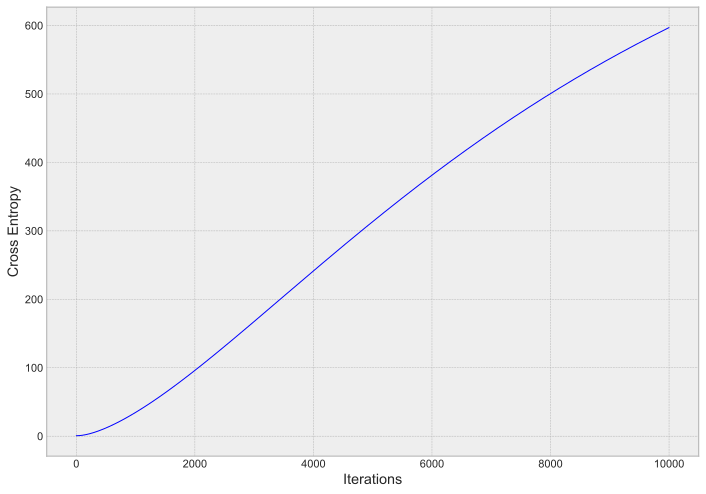

In [35]:
# Plot the J history
plt.plot(J_history, color='blue', linewidth=1)
plt.xlabel("Iterations")
plt.ylabel("Cross Entropy")

#  ✂ Drawing the Decision Boundary


In [36]:
def mapFeaturePlot(x1,x2,degree):
    out = np.ones(1)
    for i in range(1,degree+1):
        for j in range(i+1):
            terms= (x1**(i-j) * x2**j)
            out= np.hstack((out,terms))
    return out

In [37]:
def drawCircle():
  plt.scatter(X[np.where(y==1),1],X[np.where(y==1),2], label="commercialized",marker ='o')
  plt.scatter(X[np.where(y==0),1],X[np.where(y==0),2], label="not commercialized",marker ='x')

  xx = np.linspace(-1,1.5,50)
  yy= np.linspace(-1,1.5,50)
  z=np.zeros((len(xx),len(yy)))
  for i in range(len(xx)):
      for j in range(len(yy)):
          z[i,j] =mapFeaturePlot(xx[i],yy[j],6) @ theta
  plt.contour(xx,yy,z.T,0)
  plt.xlabel('x 1')
  plt.ylabel('x 2')
  plt.legend(loc=0)

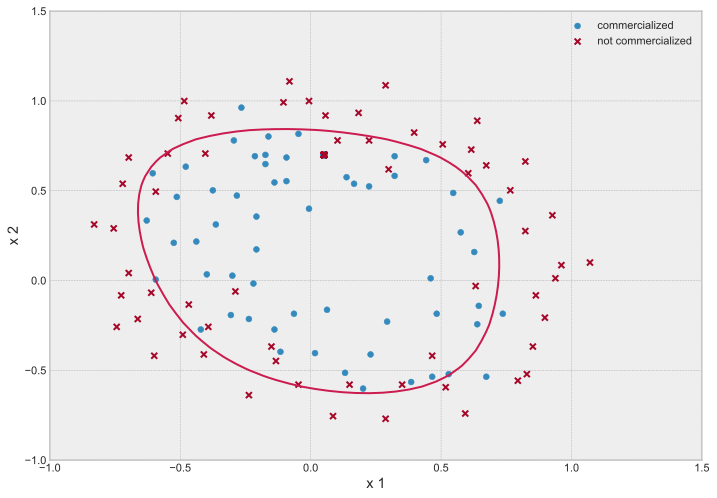

In [38]:
drawCircle() 

In [ ]:
theta

# Classification 

In [40]:
def decision_boundary(prob):
  return 1 if prob >= .5 else 0

In [41]:
def predict_proba(X,theta):
  if X.shape[0] != theta.shape[0]:
    X = mapFeature(X)
  return sigmoid(X.dot(theta))

In [42]:
def classify(predictions):
  '''
  input  - N element array of predictions between 0 and 1
  output - N element array of 0s (False) and 1s (True)
  '''
  db = np.vectorize(decision_boundary)
  return db(predictions).flatten()

# Classifier Accuracy

In [43]:
def predict_Y(X, theta):
  '''
  Returns 1D array of probabilities
  that the class label == 1
  '''
  z = np.dot(X, theta)
  return sigmoid(z)

In [44]:
def accuracy(predicted_labels, actual_labels):
  '''
  Accuracy measures how correct our predictions were. 
  In this case we simply compare predicted labels to true labels and divide by the total.
  '''
  classifications = np.where(predicted_labels > 0.5, 1, 0)
  return np.mean(classifications==actual_labels)*100 

In [54]:
y_pred = predict_Y(X,theta)
y_class = classify(y_pred)

In [55]:
accuracy(y_class,y)

49.84199942545246

# 🔬 Comparison with scikit-learn
Let's compare our implementation with the sklearn library.

In [47]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(penalty='l2')
model.fit(X,y)

c:\Users\kawaremu\anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [50]:
model.coef_.reshape(28,1)

array([[-9.40316896e-05],
       [ 6.25200403e-01],
       [ 1.18110372e+00],
       [-2.01998737e+00],
       [-9.17422545e-01],
       [-1.43161951e+00],
       [ 1.24007673e-01],
       [-3.65545995e-01],
       [-3.57235803e-01],
       [-1.75177398e-01],
       [-1.45813451e+00],
       [-5.09079430e-02],
       [-6.15531333e-01],
       [-2.74684592e-01],
       [-1.19285084e+00],
       [-2.42159297e-01],
       [-2.06009268e-01],
       [-4.46834189e-02],
       [-2.77786348e-01],
       [-2.95378201e-01],
       [-4.56358841e-01],
       [-1.04313960e+00],
       [ 2.78215032e-02],
       [-2.92419721e-01],
       [ 1.56135368e-02],
       [-3.27375607e-01],
       [-1.43860298e-01],
       [-9.24641743e-01]])

# 📚 Ressources and References

1. *Fighting Overfitting With L1 or L2*, https://neptune.ai/blog/fighting-overfitting-with-l1-or-l2-regularization
2. *Implement Logistic Regression with L2 Regularization*, https://towardsdatascience.com/implement-logistic-regression-with-l2-regularization-from-scratch-in-python-20bd4ee88a59
3. *Feature Selection and Dimensionality Reduction*, https://towardsdatascience.com/feature-selection-and-dimensionality-reduction-f488d1a035de
4. *Regularization in Python*, https://harish-reddy.medium.com/regularization-in-python-699cfbad8622